<a href="https://colab.research.google.com/github/keitotomita/kadai0/blob/master/dogsvscats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import chainer

In [16]:
!pip install chainer

In [0]:
import numpy as np
import chainer

In [0]:
import cupy

In [0]:
import numpy

In [19]:
ls

dogscats.zip  sample_data/


In [20]:
!unzip dogscats.zip

Archive:  dogscats.zip
  inflating: evaluation/cat/10.jpg   
  inflating: evaluation/cat/100.jpg  
  inflating: evaluation/cat/101.jpg  
  inflating: evaluation/cat/103.jpg  
  inflating: evaluation/cat/104.jpg  
  inflating: evaluation/cat/107.jpg  
  inflating: evaluation/cat/108.jpg  
  inflating: evaluation/cat/11.jpg   
  inflating: evaluation/cat/114.jpg  
  inflating: evaluation/cat/115.jpg  
  inflating: evaluation/cat/116.jpg  
  inflating: evaluation/cat/117.jpg  
  inflating: evaluation/cat/120.jpg  
  inflating: evaluation/cat/121.jpg  
  inflating: evaluation/cat/122.jpg  
  inflating: evaluation/cat/123.jpg  
  inflating: evaluation/cat/124.jpg  
  inflating: evaluation/cat/125.jpg  
  inflating: evaluation/cat/128.jpg  
  inflating: evaluation/cat/129.jpg  
  inflating: evaluation/cat/13.jpg   
  inflating: evaluation/cat/133.jpg  
  inflating: evaluation/cat/134.jpg  
  inflating: evaluation/cat/135.jpg  
  inflating: evaluation/cat/136.jpg  
  inflating: evaluation/cat

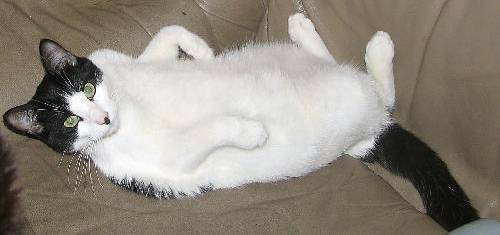

In [21]:
from PIL import Image

train_image_path = 'validation/cat/cat.12344.jpg'
Image.open(train_image_path)

In [0]:
cats_images_train_path='train/cat/'
dogs_images_train_path='train/dog/'
cats_images_valid_path='validation/cat/'
dogs_images_valid_path='validation/dog/'

image_and_teacher_label_list = []

In [0]:
import os
def get_image_teacher_label_list(dir,label):
  filepath_list = []
  files = os.listdir(dir)
  for file in files:
    filepath_list.append((dir + file,label))
  return filepath_list

In [0]:
image_and_teacher_label_list.extend(get_image_teacher_label_list(cats_images_train_path,0))
image_and_teacher_label_list.extend(get_image_teacher_label_list(dogs_images_train_path,1))
image_and_teacher_label_list.extend(get_image_teacher_label_list(cats_images_valid_path,0))
image_and_teacher_label_list.extend(get_image_teacher_label_list(dogs_images_valid_path,1))

In [26]:
print(image_and_teacher_label_list)

[('train/cat/cat.7348.jpg', 0), ('train/cat/cat.3236.jpg', 0), ('train/cat/cat.4365.jpg', 0), ('train/cat/cat.9110.jpg', 0), ('train/cat/cat.3847.jpg', 0), ('train/cat/cat.4236.jpg', 0), ('train/cat/cat.1928.jpg', 0), ('train/cat/cat.2247.jpg', 0), ('train/cat/cat.6664.jpg', 0), ('train/cat/cat.6684.jpg', 0), ('train/cat/cat.5574.jpg', 0), ('train/cat/cat.198.jpg', 0), ('train/cat/cat.7745.jpg', 0), ('train/cat/cat.2839.jpg', 0), ('train/cat/cat.594.jpg', 0), ('train/cat/cat.8262.jpg', 0), ('train/cat/cat.7113.jpg', 0), ('train/cat/cat.201.jpg', 0), ('train/cat/cat.4056.jpg', 0), ('train/cat/cat.3311.jpg', 0), ('train/cat/cat.5568.jpg', 0), ('train/cat/cat.6285.jpg', 0), ('train/cat/cat.2928.jpg', 0), ('train/cat/cat.9993.jpg', 0), ('train/cat/cat.1494.jpg', 0), ('train/cat/cat.2636.jpg', 0), ('train/cat/cat.2987.jpg', 0), ('train/cat/cat.8466.jpg', 0), ('train/cat/cat.597.jpg', 0), ('train/cat/cat.4766.jpg', 0), ('train/cat/cat.8242.jpg', 0), ('train/cat/cat.2511.jpg', 0), ('train/cat

In [0]:
def data_reshape(width_height_channel_image):
  image_array = np.array(width_height_channel_image)
  return image_array.transpose(2,0,1)

In [0]:
INPUT_WIDTH = 128
INPUT_HEIGHT = 128

In [29]:
import cv2

image_before_reshape = cv2.imread('train/cat/cat.9021.jpg')
print(image_before_reshape.shape)

image_after_reshape = data_reshape(image_before_reshape)
print(image_after_reshape.shape)

(251, 216, 3)
(3, 251, 216)


In [0]:
def adapt_data_to_convolution2d_format(input_image):
  image,label = input_image
  
  #imageのデータを8ビットの符号なし整数に変換
  image = image.astype(np.uint8)
  #Chainerの中データを用意する段階で、image.transpose(2,0,1)した(x,y,color)=>(color,x,y)
  #正しくリサイズできるため、一回データの構造を元に戻して(x,y,color)
  image = Image.fromarray(image.transpose(1,2,0))
  #共通の画像のリサイズ処理。
  result_image = image.resize((INPUT_WIDTH,INPUT_HEIGHT),Image.LANCZOS)
  #リサイズしたら、画像データをChainerのConolution2Dに使えるように戻す(color,x,y)
  image = data_reshape(result_image)
  #データを0～1の間の値に変換
  image = image.astype(np.float32)/255
  return image,label

In [0]:
from chainer.datasets import LabeledImageDataset

dogscats_dataset = LabeledImageDataset(image_and_teacher_label_list)

In [0]:
from chainer.datasets import TransformDataset

transformed_dataset = TransformDataset(dogscats_dataset,adapt_data_to_convolution2d_format)

In [0]:
from chainer import datasets

#前処理済のデータを分ける
train_data,test_data = datasets.split_dataset_random(transformed_dataset,int(len(transformed_dataset)*0.8),seed=0)

In [34]:
print(int(len(transformed_dataset)*0.8))
print(len(train_data))
print(len(test_data))

20000
20000
5000


In [35]:
print(train_data)

In [0]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training,serializers,Chain,optimizers,iterators
from chainer.training import extensions,Trainer

In [0]:
GPU_ID=0
BATCH_SIZE = 64
MAX_EPOCH = 10

In [0]:

class CNN(Chain):
  # コンストラクタ
  def __init__(self):
    super(CNN, self).__init__()

    with self.init_scope():
      self.conv1 = L.Convolution2D(None, out_channels=32, ksize=3, stride=1, pad=1)
      self.conv2 = L.Convolution2D(in_channels=32, out_channels=64, ksize=3, stride=1, pad=1)
      self.conv3 = L.Convolution2D(in_channels=64, out_channels=128, ksize=3, stride=1, pad=1)
      self.conv4 = L.Convolution2D(in_channels=128, out_channels=256, ksize=3, stride=1, pad=1)
      self.layer1 = L.Linear(None, 1000)
      self.layer2 = L.Linear(1000, 2)
  #
  def __call__(self, input):
    func = F.max_pooling_2d(F.relu(self.conv1(input)), ksize=2, stride=2)
    func = F.max_pooling_2d(F.relu(self.conv2(func)), ksize=2, stride=2)
    func = F.max_pooling_2d(F.relu(self.conv3(func)), ksize=2, stride=2)
    func = F.max_pooling_2d(F.relu(self.conv4(func)), ksize=2, stride=2)
    func = F.dropout(F.relu(self.layer1(func)), ratio=0.80)
    func = self.layer2(func)
    return func

In [39]:
model = L.Classifier(CNN())
model.to_gpu(GPU_ID)

In [0]:
# 学習用の反復子
train_iterator = iterators.MultiprocessIterator(train_data, BATCH_SIZE)
# 検証用の反復子
test_iterator = iterators.MultiprocessIterator(test_data, BATCH_SIZE, False, False)

In [0]:
optimizer = optimizers.Adam().setup(model)

In [0]:
updater = training.StandardUpdater(train_iterator, optimizer, device=GPU_ID)

In [0]:
trainer = Trainer(updater, stop_trigger=(MAX_EPOCH, 'epoch'))

In [0]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.Evaluator(test_iterator, model, device=GPU_ID), name='validation')
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))

# レポートのグラフを出力するextension
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', marker='^', grid=True, file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch',marker='^' , grid=True, file_name='accuracy.png'))

In [45]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.677538    0.601737       0.64176               0.636274                  150.963       
2           0.545107    0.72516        0.49239               0.762263                  291.361       
3           0.438726    0.796026       0.377693              0.833267                  432.113       
4           0.353775    0.844551       0.360647              0.84375                   572.749       
5           0.294779    0.874551       0.296014              0.876582                  714.552       
6           0.247553    0.895132       0.290788              0.879747                  855.944       
7           0.212331    0.911342       0.332608              0.867682                  998.008       
8           0.174996    0.928636       0.305114              0.886472                  1139.8        
9           0.149365    0.940745       0.305182              0.888449               

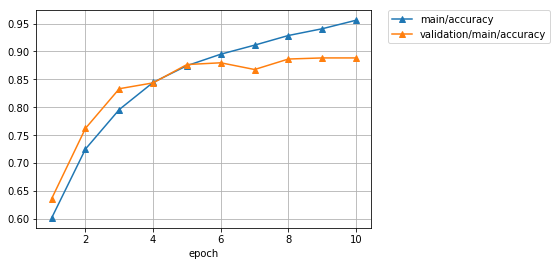

In [46]:

Image.open('result/accuracy.png')

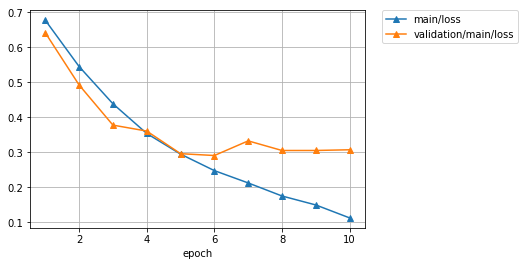

In [47]:
Image.open('result/loss.png')

In [49]:
ls

dogscats.zip  evaluation/  result/  sample_data/  train/  validation/


In [0]:
from google.colab import drive
drive.mount('/content/drive')